Single Particle Spin $\tfrac{1}{2}$ system: Pulse Shape as Input
====================================

Want to be able to represent a spin $\tfrac{1}{2}$ system so we can test the time evolution of different pulses. Our Hamiltonian can be controlled by a laser. A laser can be controlled by the intensity, frequency, and phase. While not exactly the same, these can be mapped to three parameters in our Hamiltonian:
$$
\text{intensity} \mapsto \Omega(t) \\
\text{frequency} \mapsto \Delta(t) \\
\text{phase} \mapsto \phi(t) 
$$
which appear in the Hamiltonian as follows:
$$
\hat{H}(\Delta(t), \Omega(t), \phi(t)) = \frac{-\Delta(t)}{2}\hat{1} 
    - \frac{-\Delta(t)}{2}\hat{\sigma}_z 
    + \frac{\Omega(t)}{2}
        (
            \cos{\phi(t)}\hat{\sigma}_x +
            \sin{\phi(t)}\hat{\sigma}_y
        )
    = -\frac{1}{2}\Delta(t)\hat{1} + \frac{1}{2}\tilde{\vec{\Omega}}(t) \cdot \hat{\vec{\sigma}}
$$

The `QuantumOptics` package has some of its own built in types that we will use. We also need to declare a basis we are working in. We will name these here:

In [84]:
using QuantumOptics
using LinearAlgebra

computational = SpinBasis(1//2)

I = identityoperator(computational)
σx = sigmax(computational)
σy = sigmay(computational)
σz = sigmaz(computational)
σ_vec = [σx, σy, σz];

down = spindown(computational)
up = spinup(computational)
;

The following scheme we will use is to require that the user provides the waveforms for $\Delta(t)$, $\Omega(t)$, and $\phi(t)$ and the total time $T$ they want the system to run for.  

We might also want to talk about the actual bloch sphere trajectory as the input, in which case we give the values $\theta(t)$, $\phi(t)$, and $|\tilde{\vec{\Omega}}(t)|$. 

In [ ]:

function twoLevelSysFromParameters(Δ::Function, Ω::Function, ϕ::Function, T::Real; t::Real = 0.01)
    
    H(t, ignored) = Ω(t)*σx/2 - Δ(t)*I/2 - Δ(t)*σz/2 

    tspan = [0.0:0.05:T;] 
    tout, psi_t = timeevolution.schroedinger_dynamic(tspan, down, H)
    return tout, psi_t, H
end

# TODO: add the twoLevelSysFromBlochAngles function!
# function twoLevelSysFromBlochAngles(Ω_eff_mag::Function, θ::Function, ϕ::Function, T::Float64; t::Float64 = 0.01)
#     Δ(t) = cos(θ(t))*Ω_eff_mag(t)
#     Ω(t) = -tan(θ(t))*Δ(t)
#     Ω_vec(t) = [Ω(t), Ω(t), -Δ(t)]

#     H(t, ignored) = Ω(t)*σx/2 - Δ(t)*I/2 - Δ(t)*σz/2 

#     tspan = [0.0:0.01:T;] 
#     tout, psi_t = timeevolution.schroedinger_dynamic(tspan, spindown(computational), H)
#     return tout, psi_t
# end


twoLevelSysFromParameters (generic function with 2 methods)

Now we can look at a very simple example. 
$$
\Delta = \Omega \Rightarrow \theta = \pi/4
$$

In [3]:
include("./Plotting.jl")
include("./Utils.jl")
using CairoMakie
using IJulia

Δ(t) = -1
Ω(t) = 1
ϕ(t) = 0
T=π*0.8

filename = "./graphics/simple_bloch.gif"
tout, psi_t, H = twoLevelSysFromParameters(Δ, Ω, ϕ, T)
save_bloch_animation(tout, psi_t, 3, 24, filename)

display("text/html", """
<img src="$filename" width=600>
""")

Matt Chow gate from Vikas' Python code:
```python
def Matt(T,V):     # The three parameters are t_hold(<0.5), sigma(~0.15), delta_max (negative), 
    Oset = 2*np.pi* np.array([0.0, 0.412, 0.825, 1.237, 1.485, 1.485, 1.237, 0.825, 0.412, 0.0])*1.65
    Dset = 2*np.pi* np.array([4.08, 3.06, 2.04, 1.02, 0.408, 0.408, 1.02, 2.04, 3.06, 4.08])
    
    delta = CubicSpline(np.linspace(0,T,10),Dset)
    omega = CubicSpline(np.linspace(0,T,10),Oset)
    
    phi = 0

    ..."""rest of function"""...
```
we can recreate this in Julia now.

In [82]:
using Interpolations
using CairoMakie

function mattChow(T::Real)
    fudge_factor = 1.65 # this was not part of the original gate but is needed for the simulation to match the experimental data
    Ω_points = fudge_factor*2π .* [0.0, 0.412, 0.825, 1.237, 1.485, 1.485, 1.237, 0.825, 0.412, 0.0]
    Δ_points = 2π .* [4.08, 3.06, 2.04, 1.02, 0.408, 0.408, 1.02, 2.04, 3.06, 4.08]

    ts = range(0, T, length(Ω_points))
    Ω(t) = cubic_spline_interpolation(ts, Ω_points)(t) # this could also be `Ω = cubic_spline_interpolation(ts, Ω_points)` ¯\_(ツ)_/¯
    Δ(t) = cubic_spline_interpolation(ts, Δ_points)(t)
    ϕ(t) = 0

    (tout, psi_t, H) = twoLevelSysFromParameters(Δ, Ω, ϕ, T)
    return (tout, psi_t, H), (Δ, Ω, ϕ) # returns a lot of stuff but they are all useful
end


mattChow (generic function with 1 method)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6


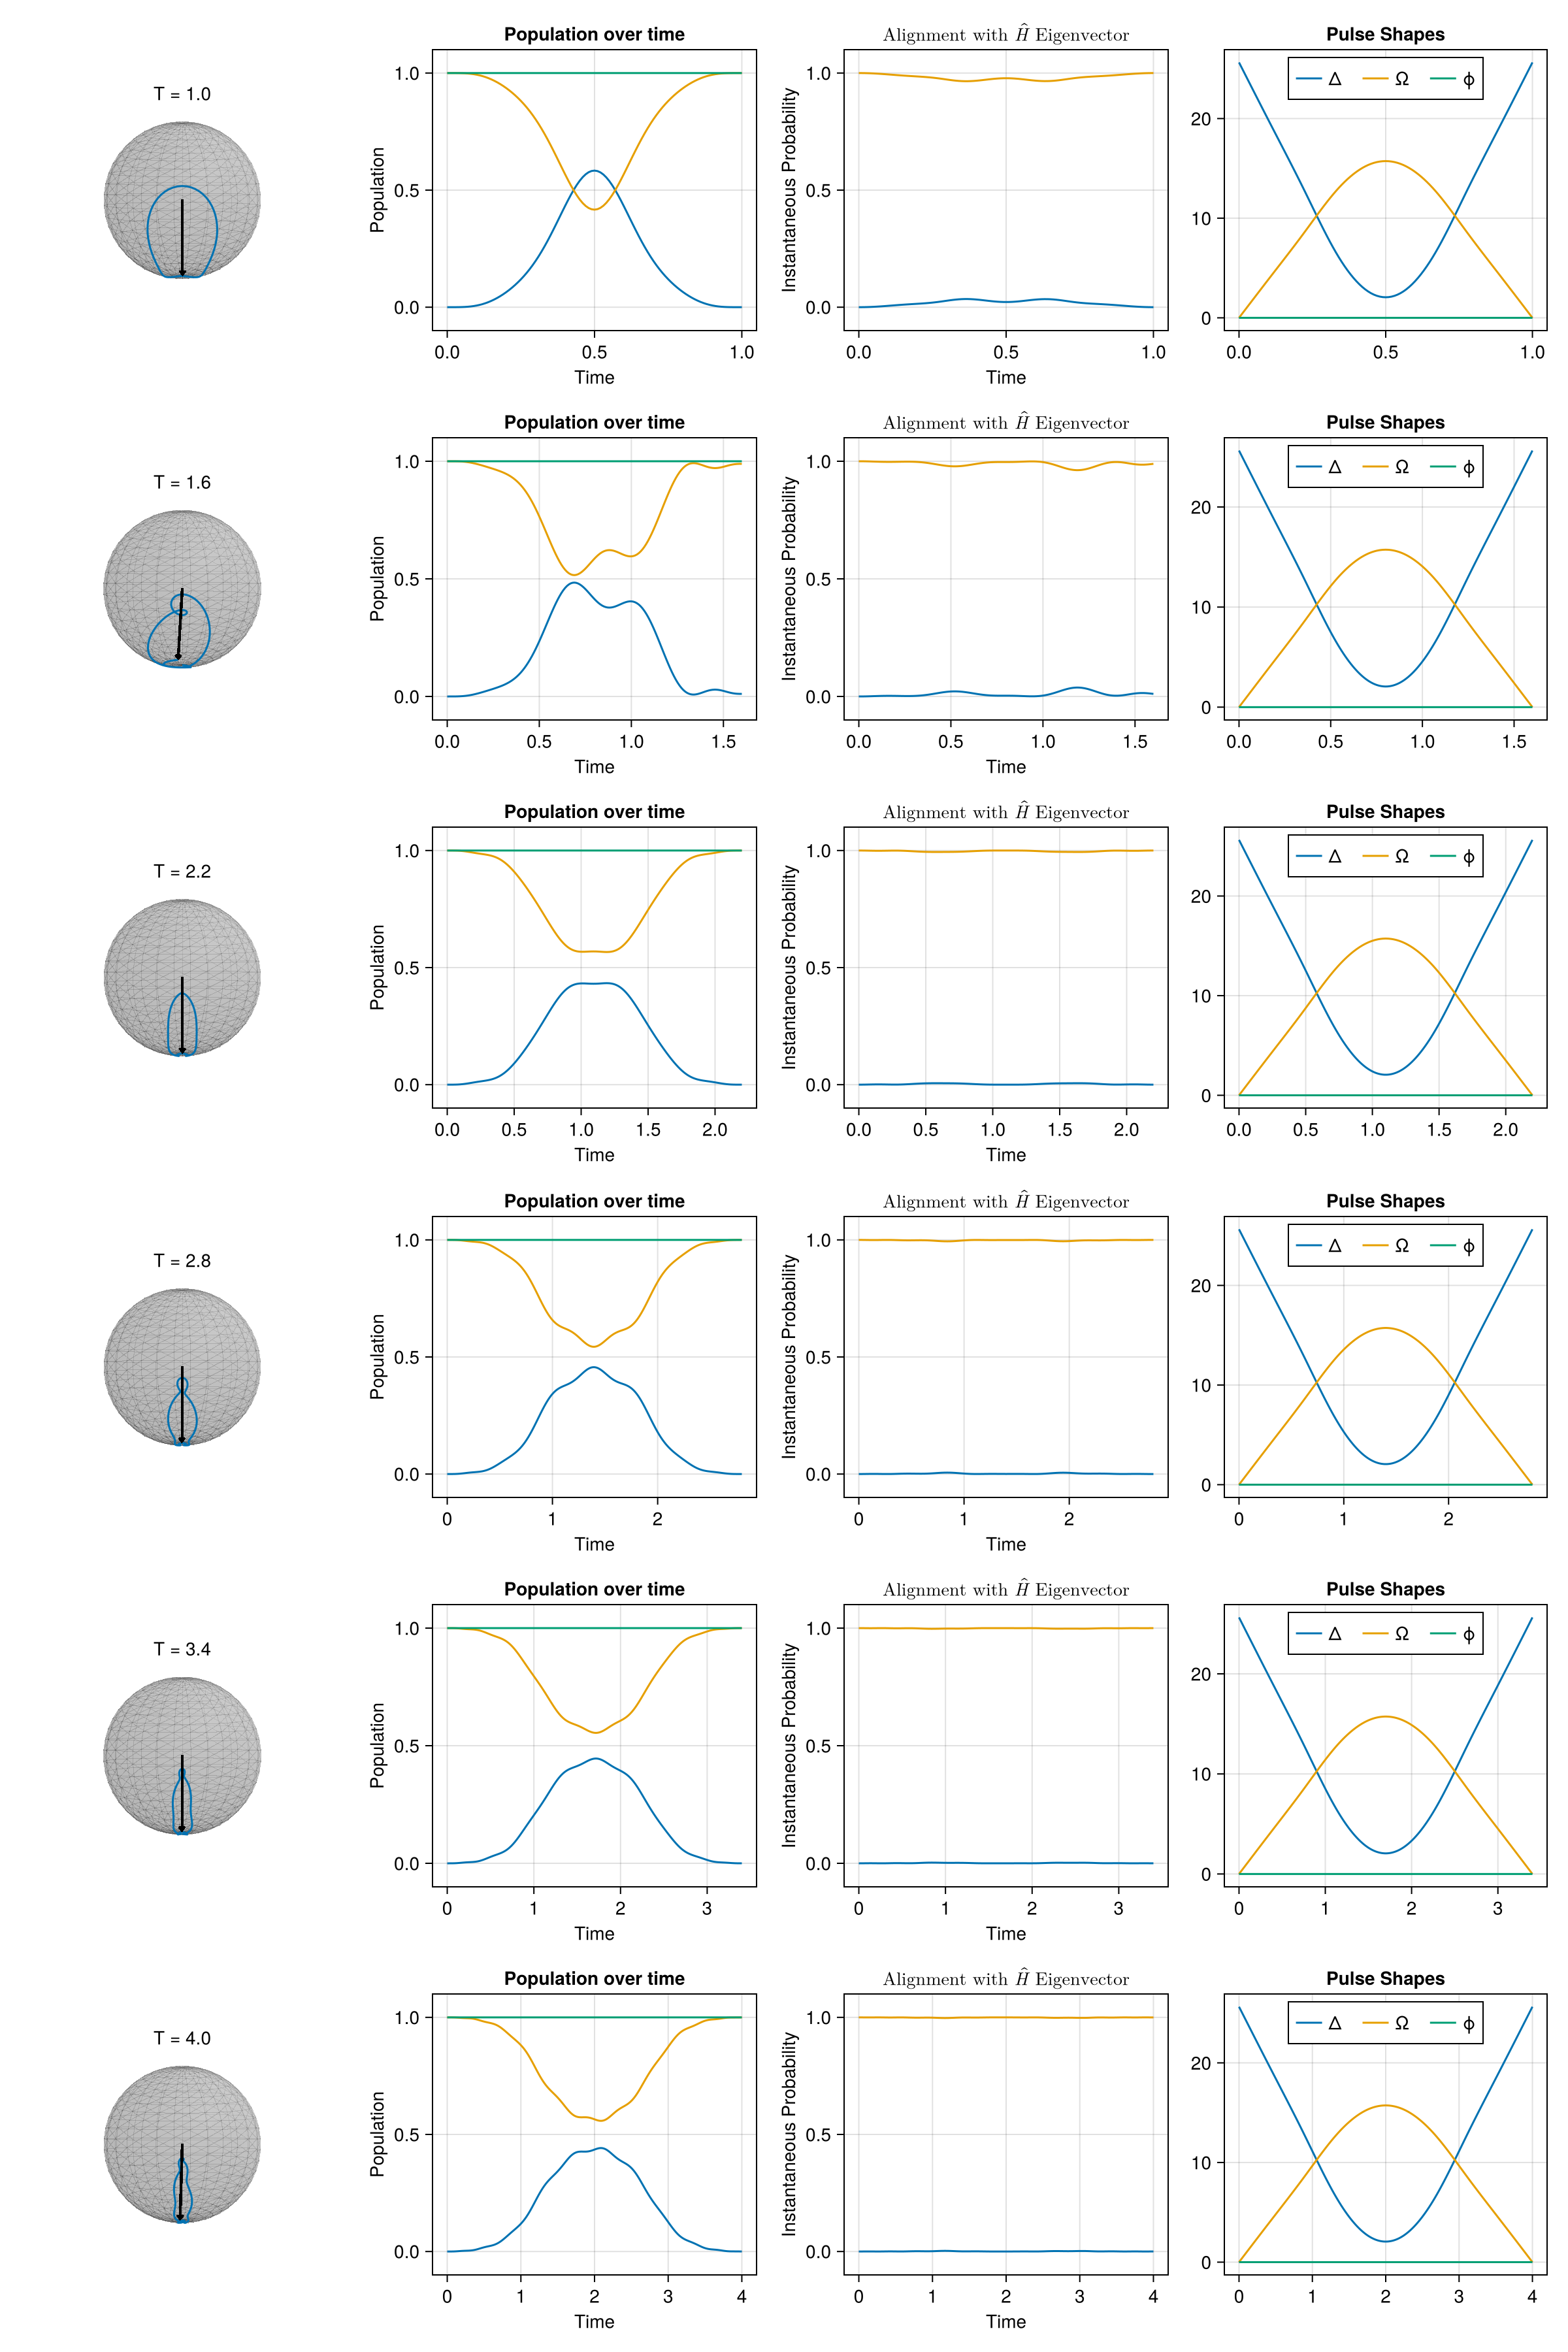

CairoMakie.Screen{IMAGE}


In [40]:
using CairoMakie

iterations = 6
fig = Figure(size = (1200, 300*iterations))
for (i,T) in enumerate(range(1, 4, iterations))
    (tout, psi_t, H), (Δ, Ω, ϕ) = mattChow(T)
    bloch = bloch_plot!(fig[i,1], tout, psi_t, title="T = $(round(T, digits=3))")
    update_cam!(bloch.scene, Vec3f(2, 0, 0), Vec3f(0, 0, 0))

    pop_ax = population_plot!(fig[i, 2], tout, psi_t)
    alignment_plot!(fig[i, 3], tout, psi_t, (t -> H(t, nothing)))

    ax = Axis(fig[i, 4], title="Pulse Shapes")
    lines!(ax, tout, Δ, label="Δ")
    lines!(ax, tout, Ω, label="Ω")
    lines!(ax, tout, ϕ, label="ϕ")
    axislegend(ax, position = :ct, orientation = :horizontal
)

    println("Iteration $i")
end
display(fig)

These plots help with some intuition but really we want to know how good we can do as we scan over all the possible gate times.

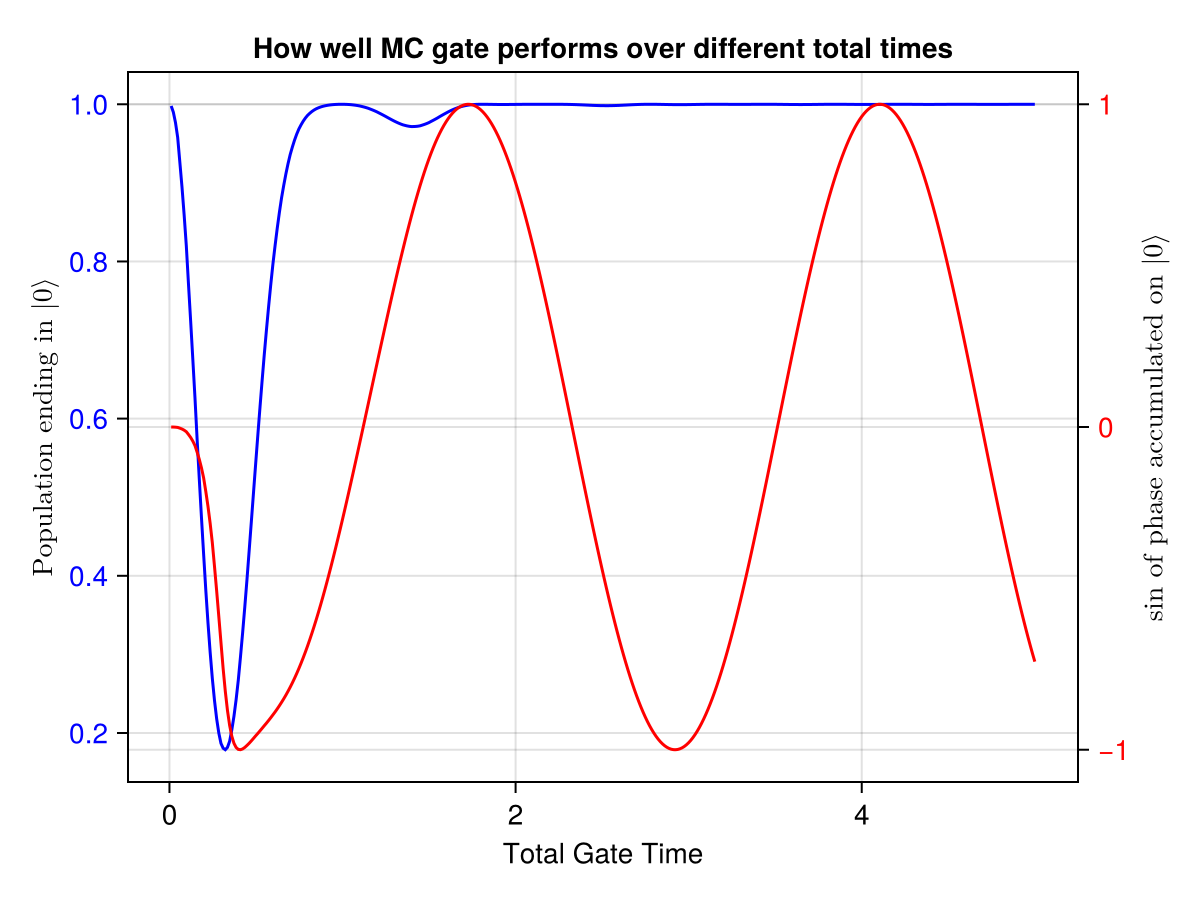

CairoMakie.Screen{IMAGE}


In [83]:
using QuantumOptics

iterations = 400
tmin = 0.01
tmax = 5
Ts = range(tmin, tmax, iterations)

function ending_population(T::Real) 
    (tout, psi_t, H), (Δ, Ω, ϕ) = mattChow(T)
    return abs2(psi_t[end][2])
end

function ending_phase(T::Real) 
    (tout, psi_t, H), (Δ, Ω, ϕ) = mattChow(T)
    return angle(psi_t[end][2])
end

# plotting
fig = Figure()
ax1 = Axis(fig[1, 1], yticklabelcolor = :blue,

    title = "How well MC gate performs over different total times",
    xlabel = "Total Gate Time",
    ylabel = L"Population ending in $|0\rangle$",
)
ax2 = Axis(fig[1, 1], yticklabelcolor = :red, yaxisposition = :right,
    yticks = [-1, 0, 1],
    # yticks = ([-π, -π/2, 0, π/2, π], ["-π", "-π/2", "0", "π/2", "π"]),
    ylabel = L"$\sin$ of phase accumulated on $|0\rangle$",
)

hidespines!(ax2)
hidexdecorations!(ax2)

lines!(ax1, Ts, ending_population, color = :blue)
lines!(ax2, Ts, x -> sin.(ending_phase(x)), color = :red)
display(fig)